# Pipeline

Today we will make a simple pipeline, and then run a Grid Search!

Import packages and data:

In [16]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection  import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

data = load_breast_cancer()
df = pd.DataFrame(data['data'],  columns =  data['feature_names'])
df['target'] =  data['target']

from sklearn import set_config
set_config(display='diagram')

**Create a train test split of the dataset**
>Set `random_state`  to 2020

In [17]:
X = df.drop('target', axis = 1)
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2020)

**Create a pipeline containing a StandardScaler object and RandomForestClassifier**

In [18]:
pipeline = make_pipeline(StandardScaler(),RandomForestClassifier(random_state=42))

**Evaluate the pipeline**

In [20]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [21]:
pipeline.score(X_test, y_test)

0.958041958041958

In [23]:
cv_score = cross_val_score(pipeline, X_train, y_train)
cv_score

array([0.97674419, 0.97647059, 0.89411765, 0.96470588, 0.97647059])

**Let's take a look at what parameters we can use in a grid search**

Below, we use the `.get_params()` method to output all of the possible parameters in a pipeline.

In [24]:
pipeline.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('randomforestclassifier', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'randomforestclassifier': RandomForestClassifier(random_state=42),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_impurity_split': None,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'ran

The thing to focus on in the dictionary above are the words following the double underscore `__`. 

Those words are the *actual* name of the parameter which you can use to reference the model's documentation!

Once we have selected parameters to tune, we can add them to a dictionary as keys, with a list of settings we would like to try as the values.

In [25]:
params = {'randomforestclassifier__max_depth': [3,5,10],
          'randomforestclassifier__max_features': [3,9,12,15],
          'randomforestclassifier__min_samples_leaf': [2,5,10]}

Now, we can feed in the pipeline and the parameters we'd like to search.

Then we fit the gridsearch pipeline to the training data.

In [26]:
grid_pipe = GridSearchCV(pipeline,params)
grid_pipe.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__max_depth': [3, 5, 10],
                         'randomforestclassifier__max_features': [3, 9, 12, 15],
                         'randomforestclassifier__min_samples_leaf': [2, 5,
                                                                      10]})

Once the grid search has completed, we can take a look at the best performing model!

In [27]:
grid_pipe.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, max_features=12,
                                        min_samples_leaf=2, random_state=42))])

In [30]:
grid_pipe.best_params_

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__max_features': 12,
 'randomforestclassifier__min_samples_leaf': 2}

We can save the best estimator to a variable and then evaluate like normal!

In [28]:
final_pipe = grid_pipe.best_estimator_

In [31]:
final_pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, max_features=12,
                                        min_samples_leaf=2, random_state=42))])

In [29]:
cross_val_score(final_pipe, X_train, y_train)

array([0.97674419, 0.98823529, 0.90588235, 0.95294118, 0.97647059])

**What do you think? Should we choose the first pipeline or the gridsearched pipeline?**

After you have selected a final model, fit the model on all of the training data and evalutate the model's performance on the testing data.

In [32]:
final_pipe.fit(X_test, y_test)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, max_features=12,
                                        min_samples_leaf=2, random_state=42))])

AttributeError: 'RandomForestClassifier' object has no attribute 'score_'

# Bootstrap Evaluation
What if we wanted to infer the range for this model's average accuracy?

We can do this via bootstrap resampling.

In [38]:
def bootstrap_model(model, X, y, iterations = 1000):
    scores = []
    for i in range(iterations):
        # Collect a random sample of data with replacement
        X_train = X.sample(n=len(X), replace=True)
        # Collect the matching target labels for the randomly samples observations
        y_train = y.loc[[x for x in X_train.index]]
        # Create a testing set made up of observations that were not randomly sampled
        X_test = X.loc[[x for x in X.index if x not in X_train.index]]
        # Collect matching target labels
        y_test = y.loc[[x for x in X_test.index]]
        # Fit model on randomly sampled data
        model.fit(X_train, y_train)
        # Score fit model on out of sample data
        score = model.score(X_test, y_test)
        # Append scores to a list
        scores.append(score)
    
    # We can use the empirical rule 
    # to identify the range of accuracy 
    # that contains 95% of the produced scores
    confidence = 0.95
    lower_percentile = ((1-confidence)/2) * 100
    upper_percentile = (confidence+((1-confidence)/2)) * 100
    lower = np.percentile(scores, lower_percentile)
    upper = np.percentile(scores, upper_percentile)
    plt.hist(scores)
    # Create confidence interval title 
    ci = f'{int(confidence*100)}% Confidence Interval\n\
    {np.round(lower, decimals=2)*100}% - {np.round(upper, decimals=2)*100}%'
    plt.title(ci)
    plt.show()
    return confidence, lower, upper

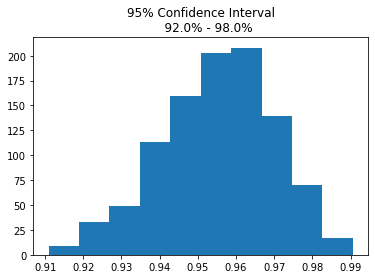

In [39]:
# This code will take a while to run!
alpha, lower, upper = bootstrap_model(final_pipe, X, y)